In [65]:
#!pip install datasets

In [66]:
import numpy as np 
from datasets import load_dataset
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import spacy
from random import seed
from random import random
import torchtext
import pickle
import os
import matplotlib.pyplot as plt

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [68]:
data_path = "preprocessed"
word2index_path = "word2index.pkl"

In [69]:
class DiffusionDataset(Dataset):
    def __init__(self, data_path, word2index_path, train_split_ratio=0.8, train=True):
        self.data_path = data_path
        with open(word2index_path, 'rb') as f:
            self.word2index = pickle.load(f)
        self.vocab_size = len(self.word2index)
        self.eos_index = self.word2index["<EOS>"]
        self.train = train
        self.train_split_ratio = train_split_ratio
        self.files = os.listdir(data_path)

        n_image_prompt = int(len(self.files) / 2) # len(self.files) must be an even number

        # Calculate the split index
        self.split_index = int((self.train_split_ratio * n_image_prompt))
        
        # Calculate the total number of rows
        self.total_rows = 0
        self.raw_prompts = pd.read_csv("raw_prompts.csv")["prompt"]

        if self.train:
            self.total_rows = self.split_index
        else:
            self.total_rows = n_image_prompt - self.split_index

    def __len__(self):
        return self.total_rows

    def __getitem__(self, idx):
        if isinstance(idx, int):
            if not self.train:
                idx += self.split_index - 1
            image = np.load(f"{data_path}\\image_{idx}.npy")
            prompt = np.load(f"{data_path}\\prompt_{idx}.npy")
            return torch.tensor(image), torch.tensor(prompt), self.raw_prompts[idx]
        else:
            image_batch = []
            prompt_batch = []
            if not self.train:
                idx = np.array(idx)
                idx += self.split_index - 1
            for i in idx:
                image = np.load(f"{data_path}\\image_{i}.npy")
                prompt = np.load(f"{data_path}\\prompt_{i}.npy")
                image_batch.append(image)
                prompt_batch.append(prompt)
                return torch.tensor(image_batch), torch.tensor(prompt_batch), self.raw_prompts[idx]

In [70]:
class EncoderCNN(nn.Module):
    def __init__(self, n_layers, hid_dim):
        super().__init__()

        self.resnet = models.efficientnet_b5(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet.classifier[1] = nn.Linear(self.resnet.classifier[1].in_features, hid_dim)

        self.hidden_size = hid_dim
        self.n_layers = n_layers

    def forward(self, images):
        """Extract feature vectors from input images."""
        features = self.resnet(images)

        batch_size = features.size(0)
        hidden = features.unsqueeze(0).expand(self.n_layers, batch_size, self.hidden_size)
        # Initialize the cell state with zeros
        cell = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(features.device)
        return hidden, cell



class DecoderRNN(nn.Module):
    def __init__(self, output_dim, emb_dim, n_layers, hid_dim, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        
        embedded = self.dropout(self.embedding(input))
        
        output, (hidden, cell) = self.rnn(embedded, (hidden.contiguous(), cell.contiguous()))
        
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

In [71]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
       
    def forward(self, src, trg, teacher_forcing_ratio = float(0.5)):

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[:, 0]

        for t in range(1, trg_len):
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token)
            if self.train:
                input = trg[:,t] if random() < teacher_forcing_ratio else top1
            else:
                input = top1
        return outputs

In [72]:
dataset = DiffusionDataset(data_path, word2index_path, train_split_ratio=0.8, train=True)

In [73]:
embed_size = 512
hidden_size = 256
output_size = dataset.vocab_size
n_layers = 2
dec_dropout = 0.5

batch_size = 64
num_epochs = 10
clip = 1

# seed random number generator
seed(1)

In [74]:
dataset.vocab_size

14638

In [75]:
encoder = EncoderCNN(n_layers, hidden_size).to(device)
decoder = DecoderRNN(output_size, embed_size, n_layers, hidden_size, dec_dropout).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

c:\Users\fruda\anaconda3\envs\AI-Lab\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fruda\anaconda3\envs\AI-Lab\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
def collate_fn(data):
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, prompts, raw_prompts = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge prompts (from tuple of 1D tensor to 2D tensor).
    lengths = [len(prompt) for prompt in prompts]
    padded_prompts = torch.full((len(prompts), max(lengths)), dataset.word2index["<PAD>"])
    #padded_prompts = torch.zeros(len(prompts), max(lengths)).long()
    for i, cap in enumerate(prompts):
        end = lengths[i]
        padded_prompts[i, :end] = cap[:end]

    return images, padded_prompts, raw_prompts, lengths

In [77]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [78]:
x = [ x[1] for x in next(iter(data_loader)) ]
x[1]

tensor([   1,    8,    6,  725, 1957,    7, 3803,    0, 3152,    5,  433, 4359,
           0, 1115,  217,    0,   40,    0,   69,   36,    0,   41,   68,    0,
           0,    0,   15,    0,   66,    0,   34,   22,    0,   31,   30,    0,
         754,    0,  866,    0, 4784, 2081, 1368, 3684, 3600,  284,   10,   11,
         580,    6, 2390, 4785,    0, 4416,  281,    0, 1368, 3902,  104, 4786,
        3244,    0, 1743,    0,  342,    2,    3,    3])

In [79]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): EncoderCNN(
    (resnet): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
                (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
       

In [80]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,095,982 trainable parameters


In [81]:
#TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
#TODO
#criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [82]:
def translate_output(output, word2index):
    index2word = {index: word for word, index in word2index.items()}  # Create index-to-word dictionary
    translated_sentences = []
    for seq in output:
        sentence = []
        for idx in seq:
            word = index2word.get(idx.item(), "<UNK>")
            if word == "<EOS>":
                break
            sentence.append(word)
        translated_sentence = " ".join(sentence)
        translated_sentences.append(translated_sentence)
    return translated_sentences

In [83]:
# for i, (images, prompts, trg_lengths) in enumerate(data_loader):
#     example_images = images
#     example_prompts = prompts
#     break

# # Translate the example prompt
# translated_example_prompts = translate_output(prompts, dataset.word2index)


In [84]:
def get_translations(images, prompts): 
    model.eval()
    with torch.no_grad():
        # Move images and prompts to the device
        images = images.to(device)
        prompts = prompts.to(device)

        # Perform forward pass for the images and prompts
        outputs = model(images, prompts)

        # Get the predicted words with the highest probability
        top1 = outputs.argmax(2).transpose(0, 1)

        # Translate the predicted output to words
        translated_output = translate_output(top1, dataset.word2index)

        return translated_output
    

In [85]:
import sys
np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=10_000)

In [86]:
# Training loop
translations_list = []  # List to store translated sentences

losses = []

for epoch in range(num_epochs):
    model.train()
    for i, (images, prompts, raw_prompts, trg_lengths) in enumerate(data_loader):
        images = images.to(device)
        prompts = prompts.to(device)

        # TODO add packing?
        #targets = pack_padded_sequence(prompts, trg_lengths, batch_first=True)[0]

        optimizer.zero_grad()
        output = model(images, prompts)

        # Remove the <sos> token and reshape the output and target tensors
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim).contiguous()

        trg = prompts.transpose(0, 1)[1:].contiguous().view(-1)
        #output_indices = np.argmax(output.cpu().detach().numpy(), axis=1)

        #print(f"Output Prompt: {output_indices}\nOutput Prompt Length: {len(output_indices)},\nTarget Prompt: {trg}\nTarget Prompt Length: {len(trg)}")

        loss = criterion(output, trg)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        losses.append(loss.item())
        if i % batch_size == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch + 1, num_epochs, i, len(data_loader), loss.item(), np.exp(loss.item())))

    # Get translations after each epoch and append to the list
    #translations_list.append(get_translations(example_images, example_prompts))

Epoch [1/10], Step [0/1250], Loss: 9.5328, Perplexity: 13804.9244
Epoch [1/10], Step [64/1250], Loss: 3.3723, Perplexity: 29.1458
Epoch [1/10], Step [128/1250], Loss: 2.7639, Perplexity: 15.8619
Epoch [1/10], Step [192/1250], Loss: 2.4938, Perplexity: 12.1078
Epoch [1/10], Step [256/1250], Loss: 2.6244, Perplexity: 13.7962
Epoch [1/10], Step [320/1250], Loss: 2.2234, Perplexity: 9.2384
Epoch [1/10], Step [384/1250], Loss: 2.4751, Perplexity: 11.8833
Epoch [1/10], Step [448/1250], Loss: 2.3457, Perplexity: 10.4402
Epoch [1/10], Step [512/1250], Loss: 1.9952, Perplexity: 7.3536
Epoch [1/10], Step [576/1250], Loss: 2.4562, Perplexity: 11.6602
Epoch [1/10], Step [640/1250], Loss: 2.4832, Perplexity: 11.9800
Epoch [1/10], Step [704/1250], Loss: 2.2298, Perplexity: 9.2984
Epoch [1/10], Step [768/1250], Loss: 1.9317, Perplexity: 6.9010
Epoch [1/10], Step [832/1250], Loss: 1.7125, Perplexity: 5.5430
Epoch [1/10], Step [896/1250], Loss: 2.0858, Perplexity: 8.0513
Epoch [1/10], Step [960/1250], 

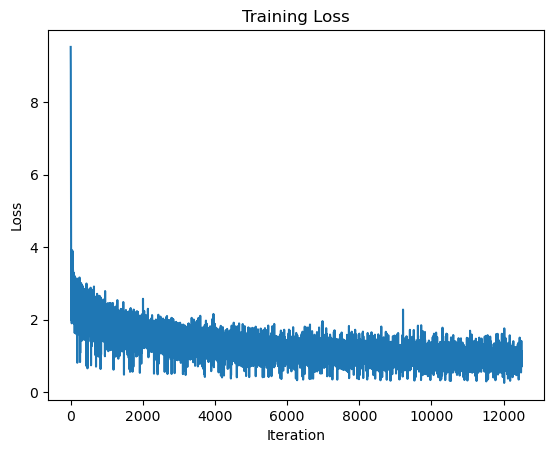

In [87]:
# Plot the losses
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

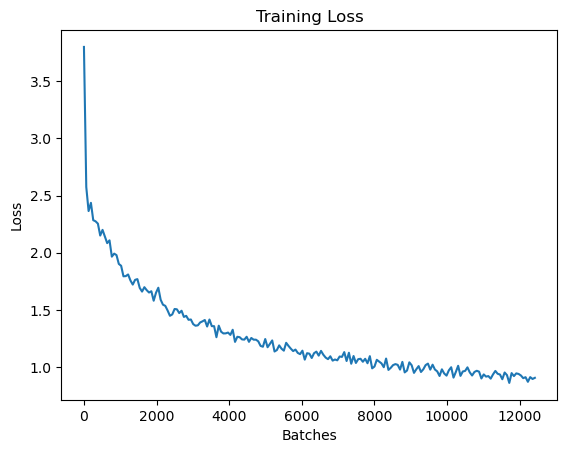

In [88]:
averaged_losses = []
for i in range(batch_size, len(losses), batch_size):
    averaged_losses.append(np.array(losses[i-batch_size:i]).mean())


# Plot the losses
plt.plot(np.arange(0, len(losses)-batch_size, batch_size), averaged_losses)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [89]:
len(losses)

12500

In [90]:
torch.save(model.state_dict(), 'parameters/seq2seq_v5_5.pth')

In [91]:
encoder = EncoderCNN(n_layers, hidden_size).to(device)
decoder = DecoderRNN(output_size, embed_size, n_layers, hidden_size, dec_dropout).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)
model.load_state_dict(torch.load("parameters/seq2seq_v5_5.pth"))
model.eval()

Seq2Seq(
  (encoder): EncoderCNN(
    (resnet): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
                (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
       

In [92]:
test_dataset = DiffusionDataset(data_path, word2index_path, train_split_ratio=0.8, train=False)
test_loader = DataLoader(test_dataset, batch_size, collate_fn=collate_fn)

In [93]:
index2word = {index: word for word, index in test_dataset.word2index.items()}

In [94]:
def translate_plain(output, index2word):
    translated_sentences = []
    for seq in output:
        sentence = []
        for idx in seq:
            word = index2word.get(idx.item(), "<UNK>")
            if word != "<EOS>":
                sentence.append(word)
        
        translated_sentences.append(" ".join(sentence))
    return translated_sentences

In [95]:
import spacy

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to embed a word using spaCy
def embed_word(word):
    return nlp(str(word)).vector

# Function to embed a batch of sentences with variable sizes
def embed_batch(batch):
    embedded_batch = []
    for sentence in batch:
        embedded_sentence = []
        for word in sentence:
            embedded_word = embed_word(word)
            embedded_sentence.append(embedded_word)
        embedded_batch.append(embedded_sentence)
    return embedded_batch

In [96]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)
model.eval()  # Set the model to evaluation mode
total_cosine_similarity = 0
total_examples = 0

with torch.no_grad():
    for i, (images, prompts, raw_prompts, trg_lengths) in enumerate(test_loader):
        images = images.to(device)
        prompts = prompts.to(device)

        output = model(images, prompts)
        
        output_sentences = output.argmax(2).transpose(0, 1)
        translated_output = translate_plain(output_sentences, index2word)
        #print(f"Translated Output: {translated_output[0]},\n Actual prompt: {raw_prompts[0]}")
        embedded_output = st_model.encode(translated_output)


        embedded_prompts = st_model.encode(raw_prompts)
        #print(f"Translated Output: {translated_output[0]},\n Actual Prompt: {raw_prompts[0]}")
        cosine_similarities = cosine_similarity(embedded_output, embedded_prompts)
        mean_cosine_similarity = cosine_similarities.mean()

        total_cosine_similarity += mean_cosine_similarity
        total_examples += 1

        if i % 1 == 0:
            print('Test Step [{}/{}], Mean Cosine Similarity: {:5.4f}'
                  .format(i, len(test_loader), mean_cosine_similarity))

average_cosine_similarity = total_cosine_similarity / total_examples
print('Average Mean Cosine Similarity: {:5.4f}'.format(average_cosine_similarity))

Test Step [0/313], Mean Cosine Similarity: 0.1625
Test Step [1/313], Mean Cosine Similarity: 0.2342
Test Step [2/313], Mean Cosine Similarity: 0.0555
Test Step [3/313], Mean Cosine Similarity: 0.1594
Test Step [4/313], Mean Cosine Similarity: 0.1609
Test Step [5/313], Mean Cosine Similarity: 0.1138
Test Step [6/313], Mean Cosine Similarity: 0.0853
Test Step [7/313], Mean Cosine Similarity: 0.0995
Test Step [8/313], Mean Cosine Similarity: 0.1322
Test Step [9/313], Mean Cosine Similarity: 0.1040
Test Step [10/313], Mean Cosine Similarity: 0.1130
Test Step [11/313], Mean Cosine Similarity: 0.1481
Test Step [12/313], Mean Cosine Similarity: 0.1455
Test Step [13/313], Mean Cosine Similarity: 0.0603
Test Step [14/313], Mean Cosine Similarity: 0.1726
Test Step [15/313], Mean Cosine Similarity: 0.0998
Test Step [16/313], Mean Cosine Similarity: 0.1622
Test Step [17/313], Mean Cosine Similarity: 0.2318
Test Step [18/313], Mean Cosine Similarity: 0.2096
Test Step [19/313], Mean Cosine Similarit